In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

import numpy as np

import pandas as pd
import sqlite3

from scipy.stats import gaussian_kde as kde
from scipy import stats

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram

from tqdm import tqdm

np.random.seed(0)

conn = sqlite3.connect('shot.db')

shots = pd.read_sql('SELECT player_id, x_loc, y_loc, make FROM shots', conn)
player_info = pd.read_sql('SELECT * FROM players', conn)
player_info.loc[:, 'label'] = player_info['Name'] + ', ' + player_info['Height'] + ', ' + player_info['Weight']
shots.head()

,player_id,x_loc,y_loc,make
0,randlju01,0,21,0
1,randlju01,247,50,0
2,paytoel01,242,43,0
3,barrerj01,49,226,1
4,barrerj01,423,233,1


In [2]:
len(shots.query('player_id == "curryst01"'))

1079

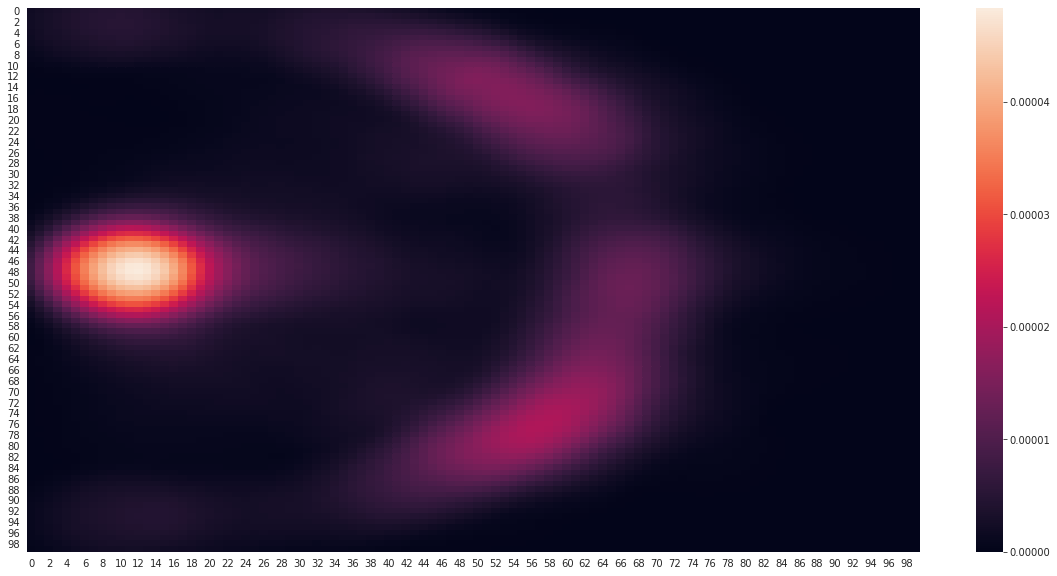

In [3]:
def fit_player_kde(shots, player_id, n_x, n_y, bw = 50, kde_type = 'AllShots', kernel = 'epanechnikov'):

    player_shots = shots.query('player_id == @player_id')
    if kde_type == 'Makes':
        player_shots = player_shots.query('make == 1')
    elif kde_type == 'Misses': 
        player_shots = player_shots.query('make == 0')
    kd = KernelDensity(kernel = kernel, bandwidth = bw)
    kd.fit(player_shots[['x_loc', 'y_loc']])

    X, Y = np.mgrid[0:500:n_x * 1j, 0:450:n_y * 1j]
    
    points = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis = 1)
    log_probs = kd.score_samples(points)
    probs = np.exp(log_probs).reshape(n_x, n_y)
    
    return probs.reshape(n_x, n_y)

steph_probs = fit_player_kde(shots, 'curryst01', 100, 100)
plt.figure(figsize = (20, 10))

sns.heatmap(steph_probs)

plt.savefig('StephChoices.png')

$$
P(make|location) = \frac{P(location|make) * P(make)}{P(location)}
$$

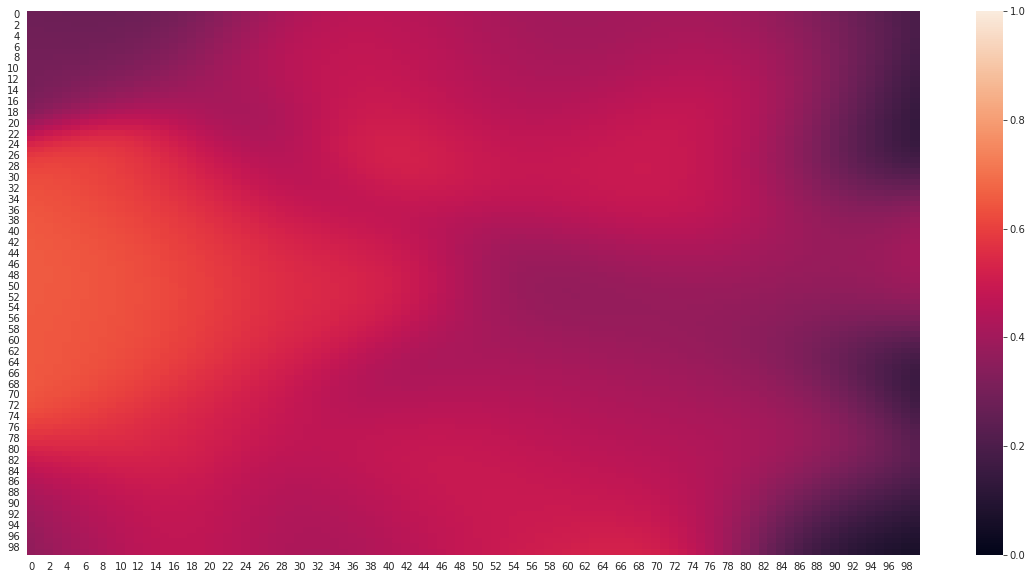

In [4]:
def get_player_pct(shots, player_id, n_x, n_y, bw, kernel = ['epanechnikov', 'epanechnikov']):
    makes = fit_player_kde(shots, player_id, n_x, n_y, bw = bw, kde_type = 'Makes', kernel = kernel[0])
    misses = fit_player_kde(shots, player_id, n_x, n_y, bw = bw, kde_type = 'Misses', kernel = kernel[1])
    
    makes /= makes.sum()
    misses /= misses.sum()
    
    makes = makes
    misses = misses
    
    make_pct = shots.query('player_id == @player_id')['make'].mean()
    
    total = make_pct * makes + (1 - make_pct) * misses
    
    return make_pct * makes.round(10) / total
    
est_pct = get_player_pct(shots, 'curryst01', 100, 100, 40, kernel = ['gaussian', 'gaussian'])

plt.figure(figsize = (20, 10))
sns.heatmap(est_pct, vmax = 1, vmin = 0)
plt.savefig('StephAcc.png')

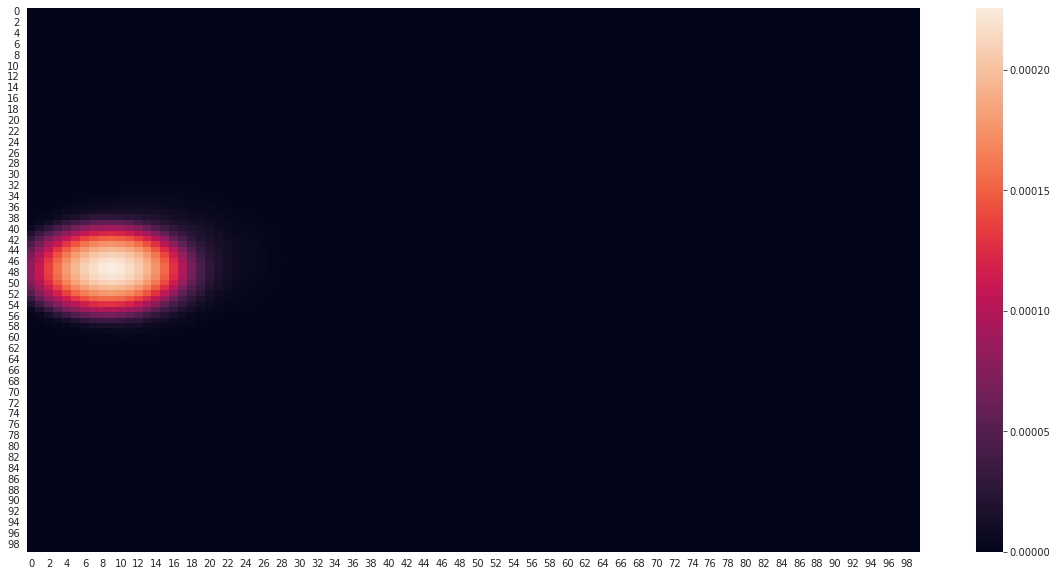

In [13]:
dj_probs = fit_player_kde(shots, 'jordade01', 100, 100)
plt.figure(figsize = (20, 10))

sns.heatmap(dj_probs)

plt.savefig('DJChoices.png')

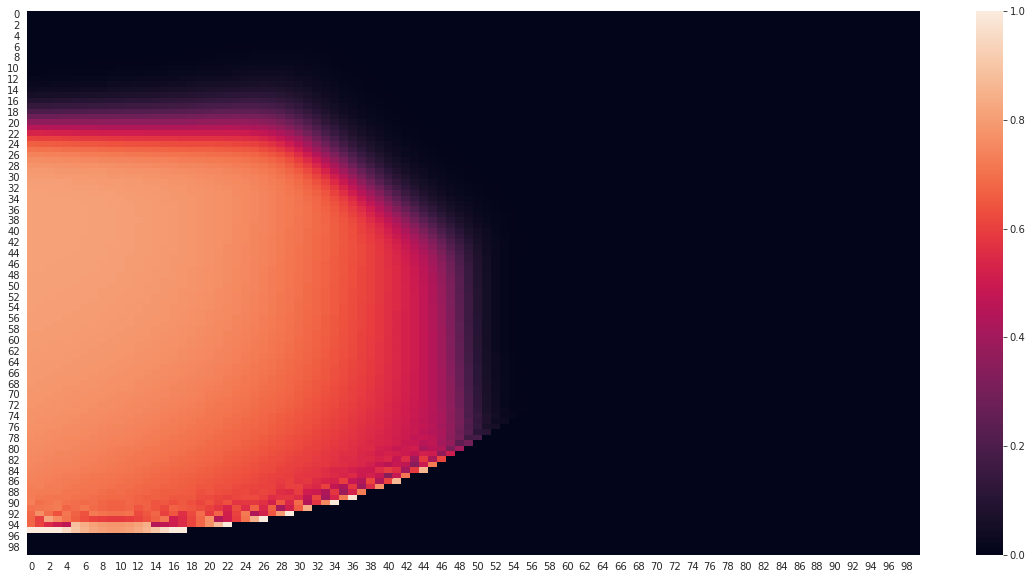

In [12]:
est_pct = get_player_pct(shots, 'jordade01', 100, 100, 40, kernel = ['gaussian', 'gaussian'])

plt.figure(figsize = (20, 10))
sns.heatmap(est_pct, vmax = 1, vmin = 0)
plt.savefig('DJAcc.png')

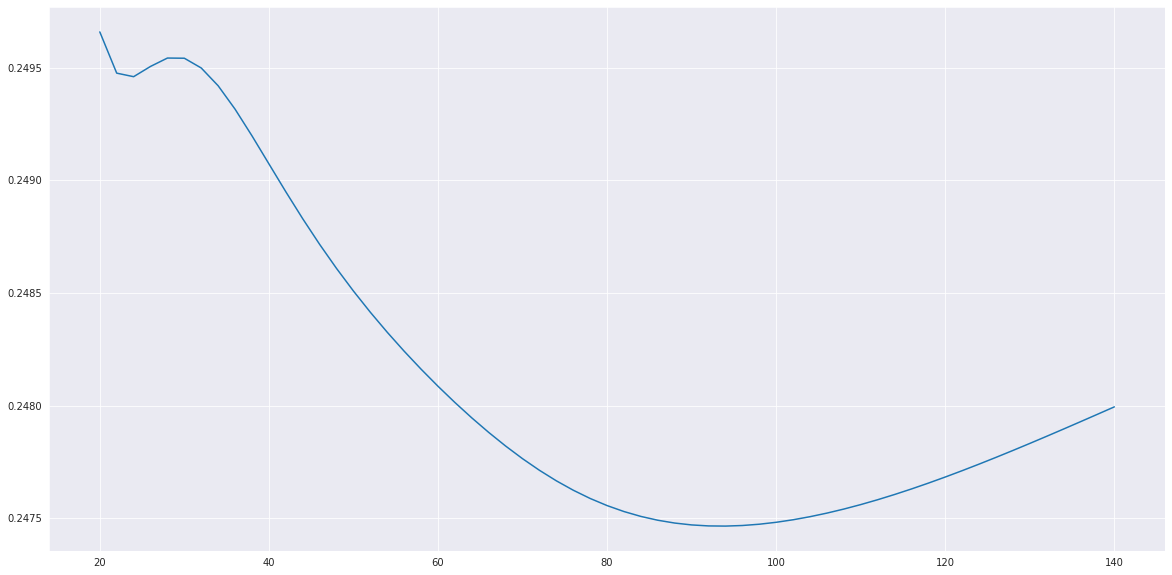

In [5]:
def calc_mse(shots, kde):
    locs = shots[['x_loc', 'y_loc']]/pd.Series({'x_loc' : 500/kde.shape[0], 'y_loc': 450/kde.shape[1]})
    s = pd.concat([shots, locs.round().astype(int).rename(columns = {'x_loc': 'x_int', 'y_loc' : 'y_int'})], axis = 1)
    s = s.replace(20, 19)
    
    s.loc[:, 'pred'] = s.apply(lambda row: kde[row['x_int'], row['y_int']], axis = 1)
    s.loc[:, 'err'] = s['pred'] - s['make']
    s.loc[:, 'SE'] = s['err'] ** 2
    
    return s['SE'].mean()

def mse_by_bw(shots, player_id, kernel = 'gaussian', n_x = 100, n_y = 100):
    bws = np.linspace(20, 140, num = 61)
    mses = np.empty_like(bws)
    
    sub = shots.query('player_id == @player_id')
    train, test = train_test_split(sub, test_size = 0.2)
    for i, bw in enumerate(bws):
        est_pct = get_player_pct(train, player_id, n_x, n_y, bw, kernel = [kernel, kernel])
        mse = calc_mse(test, est_pct)
        mses[i] = mse
        
    return bws, mses
    
bws, mses = mse_by_bw(shots, 'curryst01', n_x = 20, n_y = 20)

plt.figure(figsize = (20, 10))
plt.plot(bws, mses)

In [6]:
players = shots['player_id'].unique()

min_shots = 150

choice_dims = {'x' : 20, 'y' : 20}
acc_dims = {'x' : 20, 'y' : 20}

keeps = shots.groupby('player_id')['x_loc'].count()
keeps = keeps[keeps > min_shots].index

profiles = np.empty((len(keeps), choice_dims['x'] * choice_dims['y'] + acc_dims['x'] * acc_dims['y']))

player_bws = np.empty(len(keeps))

for i, p in enumerate(tqdm(keeps)):
    #first we get the player's shot choice chart, then their accuracy chart. Can vary ratio of sizes for importance in clustering
    shot_choice = fit_player_kde(shots, p, choice_dims['x'], choice_dims['y'])
    
    bws, mses = mse_by_bw(shots, p, n_x = acc_dims['x'], n_y = acc_dims['y'])
    best_bw = bws[np.argmin(mses)]
    accuracy = get_player_pct(shots, p, acc_dims['x'], acc_dims['y'], best_bw, kernel = ['gaussian', 'gaussian'])
    
    profiles[i, :] = np.concatenate([shot_choice.flatten(), accuracy.flatten()])
    player_bws[i] = best_bw

100%|██████████| 325/325 [09:13<00:00,  1.70s/it]


In [7]:
profiles.shape

(325, 800)

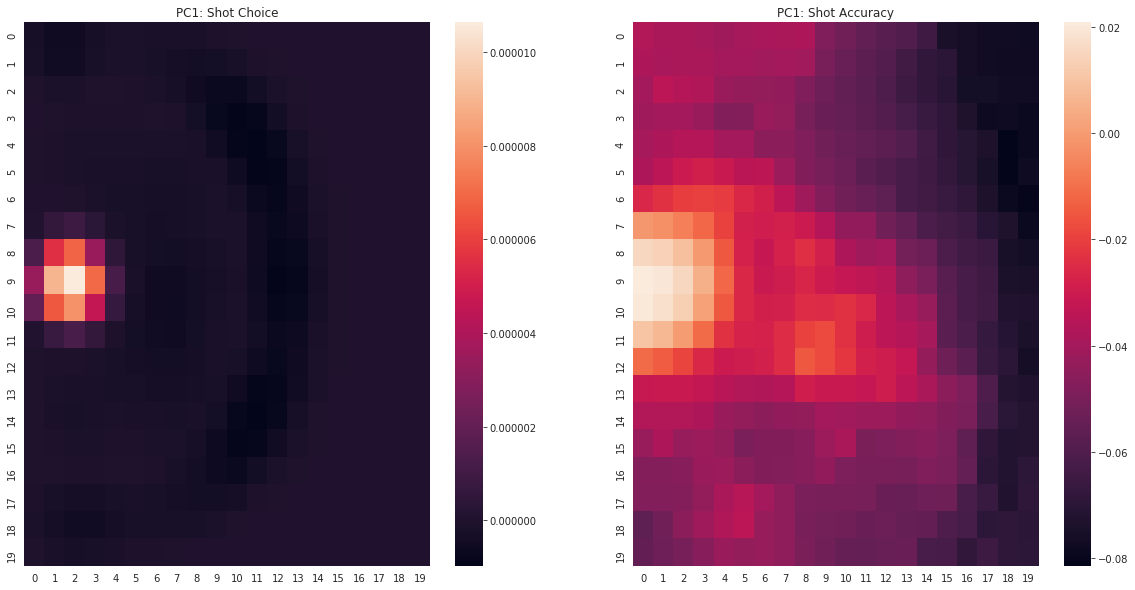

In [8]:
pca = PCA(n_components = 100)
player_pcs = pca.fit_transform(profiles)

exp_var = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize = (20, 10))

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

sns.heatmap(pca.components_[0][:400].reshape(20, 20), ax = ax1)
sns.heatmap(pca.components_[0][400:].reshape(20, 20), ax = ax2)

ax1.set_title('PC1: Shot Choice')
ax2.set_title('PC1: Shot Accuracy')

plt.savefig('PC1.png', bbox_inches = 'tight')

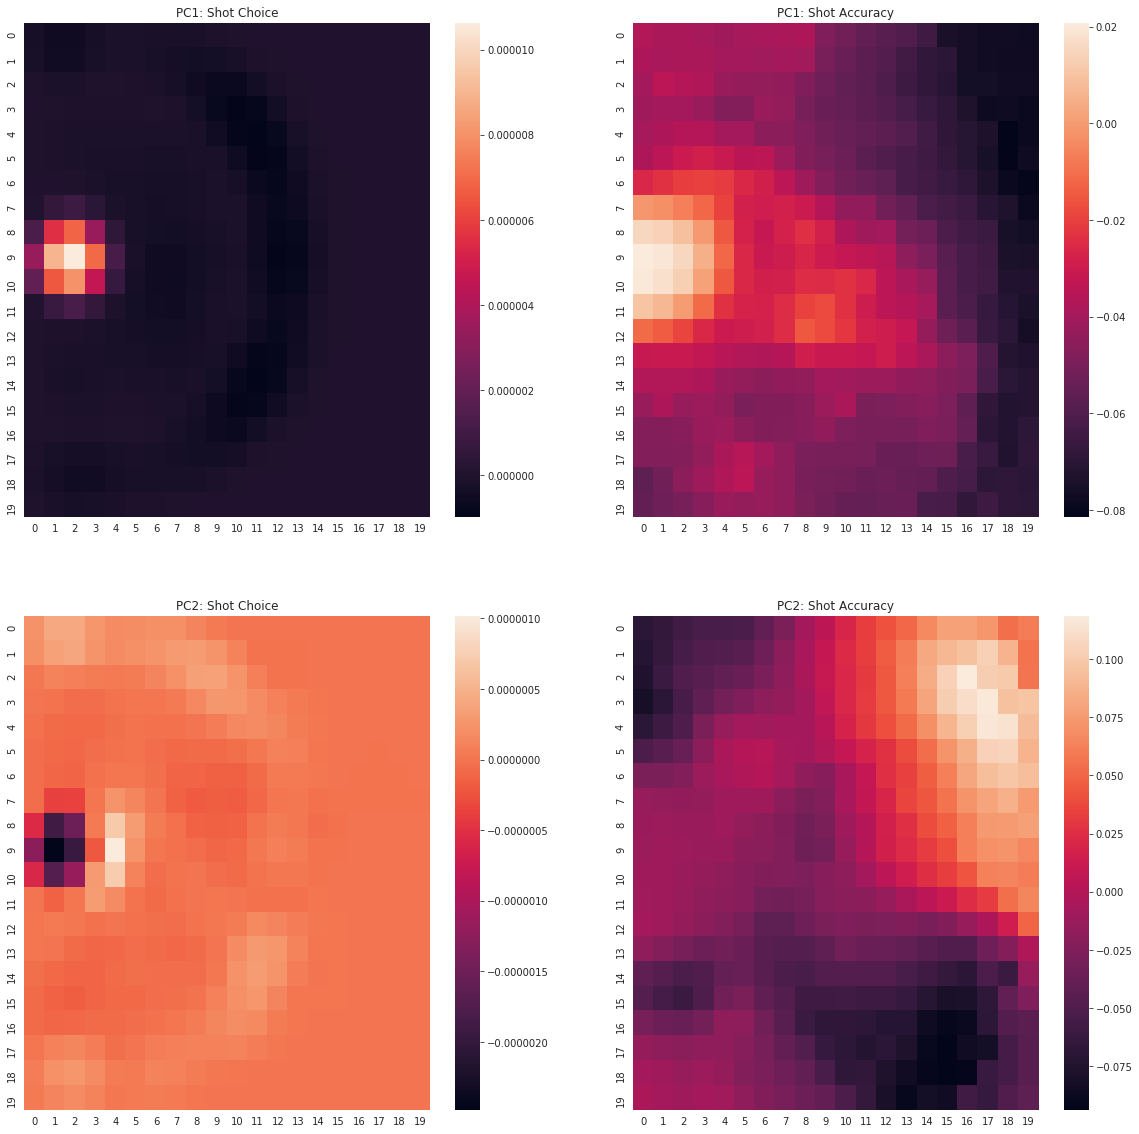

In [9]:
plt.figure(figsize = (20, 20))

ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

sns.heatmap(pca.components_[0][:400].reshape(20, 20), ax = ax1)
sns.heatmap(pca.components_[0][400:].reshape(20, 20), ax = ax2)
sns.heatmap(pca.components_[1][:400].reshape(20, 20), ax = ax3)
sns.heatmap(pca.components_[1][400:].reshape(20, 20), ax = ax4)

ax1.set_title('PC1: Shot Choice')
ax2.set_title('PC1: Shot Accuracy')
ax3.set_title('PC2: Shot Choice')
ax4.set_title('PC2: Shot Accuracy')

plt.savefig('PC_12.png', bbox_inches = 'tight')

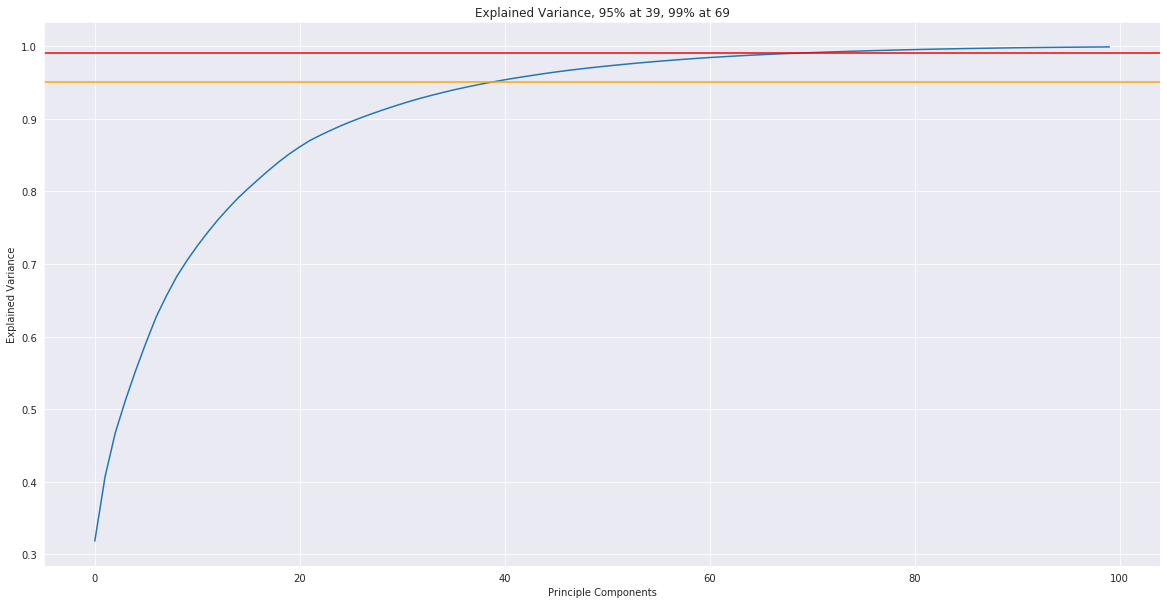

In [10]:
thresh95 = (exp_var < 0.95).sum()
thresh99 = (exp_var < 0.99).sum()

plt.figure(figsize = (20, 10))
plt.plot(exp_var)
ax = plt.gca()
ax.axhline(0.95, color = 'orange')
ax.axhline(0.99, color = 'red')

ax.set_title(f'Explained Variance, 95% at {thresh95}, 99% at {thresh99}')
ax.set_xlabel('Principle Components')
ax.set_ylabel('Explained Variance')

plt.savefig('ExplainedVariance.png')

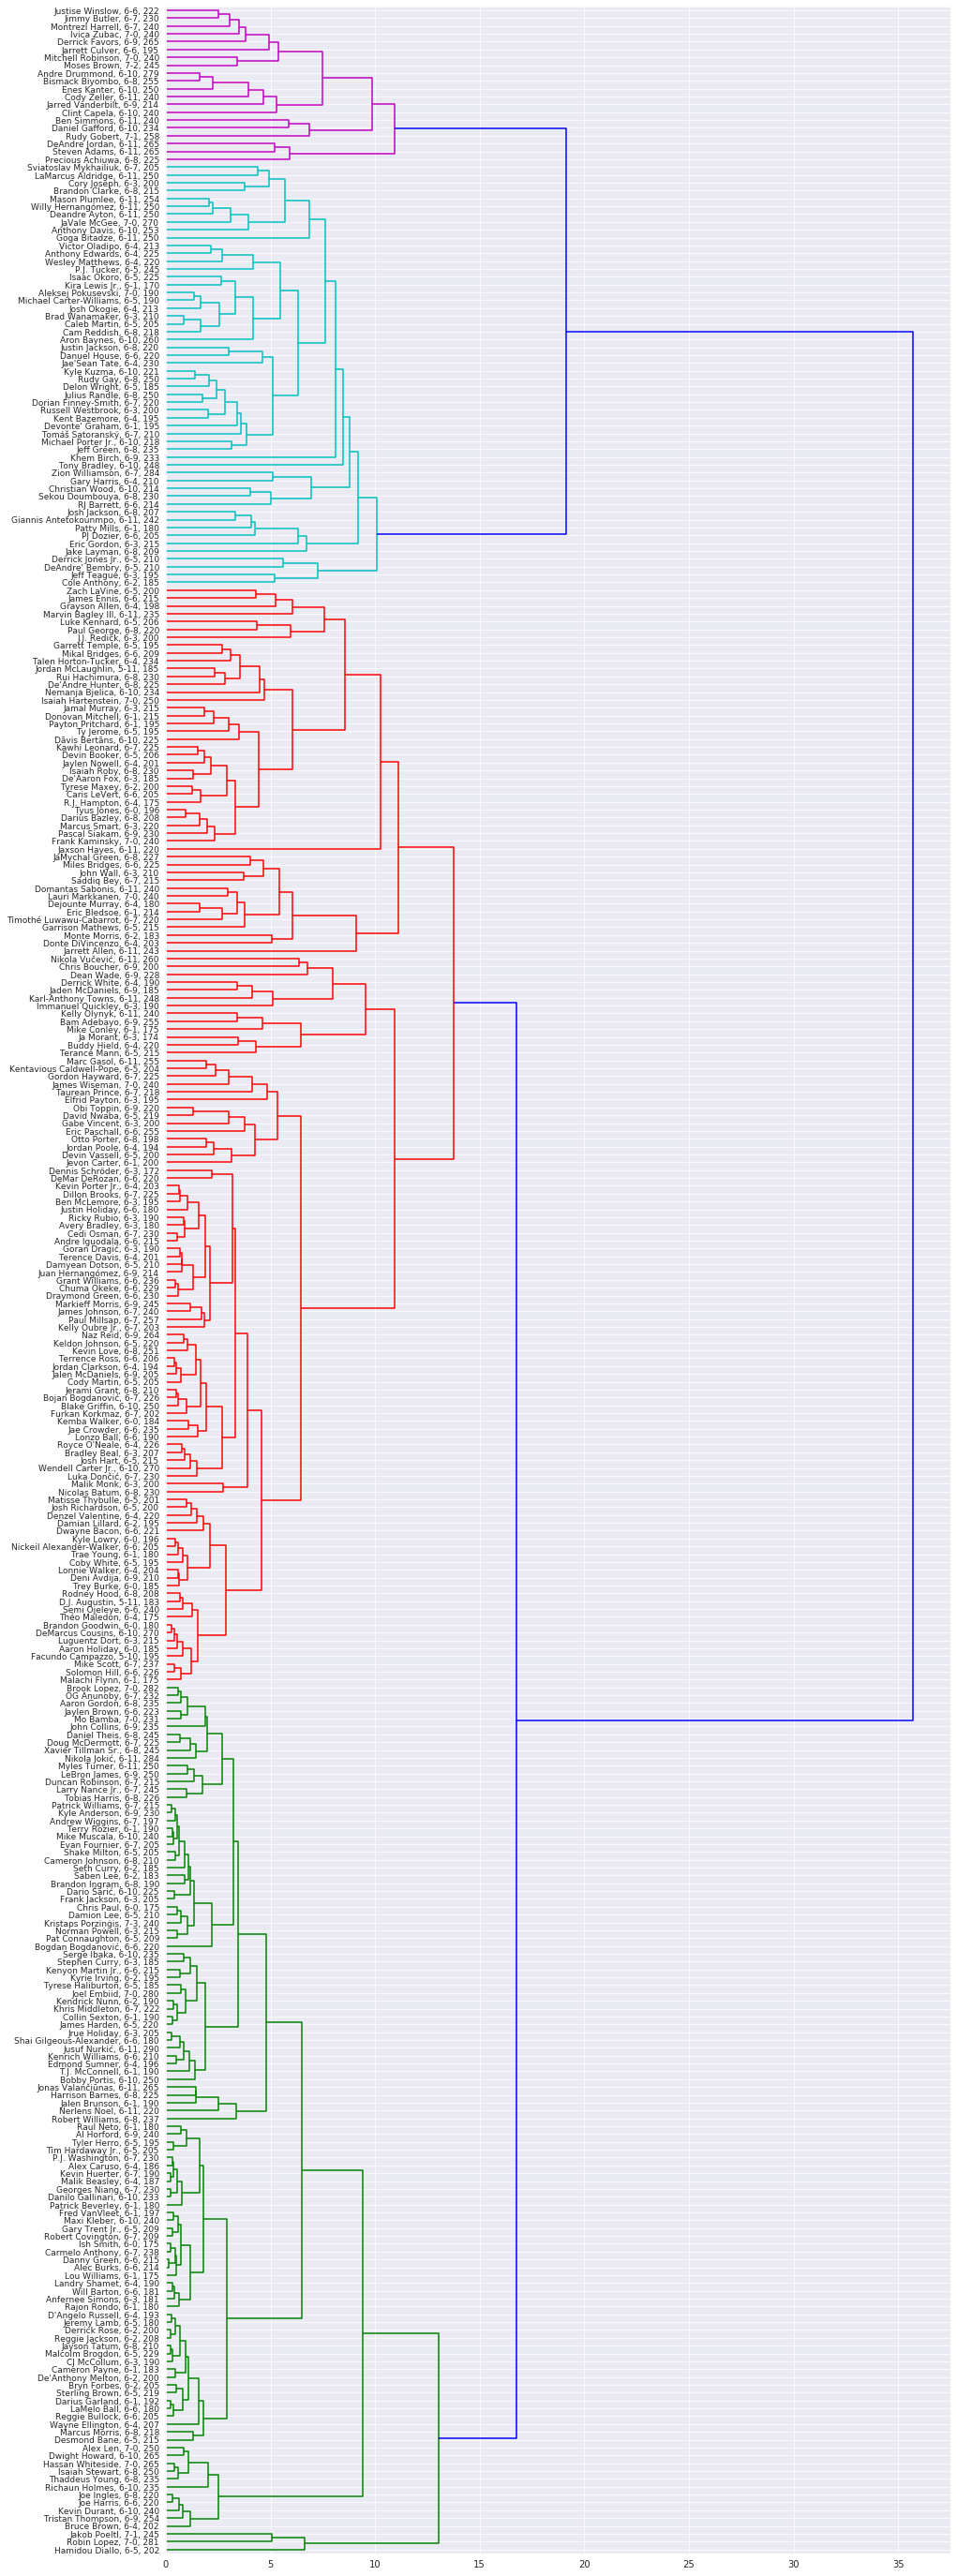

In [11]:
agg = AgglomerativeClustering(distance_threshold=0, n_clusters = None)
agg_clusters = agg.fit_predict(player_pcs[:, :thresh95])

def get_label(player_id):
    lab = player_info.query('player_id == @player_id').iloc[0]['label']
    return lab

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix,  **kwargs)

plt.figure(figsize = (15, 50))
plot_dendrogram(agg, orientation = 'right', color_threshold = 14)

locs, labels = plt.yticks()
lab_ord = [keeps[int(i.get_text())] for i in labels]
new_labs = [get_label(x) for x in lab_ord]

plt.yticks(locs, new_labs, size = 9)

plt.savefig('dendo1.png', bbox_inches = "tight")